# Анализ параметров 2

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [3]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [4]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    #def T_r(self):
    #    '''
    #    Кинетическая энергия отнсительнго движения
    #    '''
    #    return self.m_r * np.sum(((self.c_r - self.vel)  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

In [5]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.abs(np.sum(self.s1.c_r * self.s2.c_r, axis = 0)/(self.s1.length_vel() * self.s2.length_vel())))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
        
    def lmbd2(self):
        '''для подсчёта лямбда'''
        return  np.sum(self.s1.T_r()), np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()), np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.mean(self.s1.T_r() / self.s1.Full_Energy_r()),\
                np.mean(self.s2.T_r() / self.s2.Full_Energy_r())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [6]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 1.9, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. косинс угла
     2. lambda до и после
     3. lambda_1 до и после
     4. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            # lambda
            lmbd1, lmbd2 = s.lmbd()
            lmbd1_t, lmbd2_t = s.lmbd_1()
            
            # угол
            angle = s.angle()
            
            # T
            T1,H1,T2,H2 = s.lmbd2()
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['angle'] = [] 
                
                result_v[c_r_i_str]['l1'] = []          
                result_v[c_r_i_str]['l2'] = []             
                result_v[c_r_i_str]['l1_t'] = []          
                result_v[c_r_i_str]['l2_t'] = [] 
                   
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []             
                result_v[c_r_i_str]['T1'] = []          
                result_v[c_r_i_str]['T2'] = [] 
                   
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['angle'] = []
                
                result_b[b_str]['l1'] = []          
                result_b[b_str]['l2'] = []             
                result_b[b_str]['l1_t'] = []          
                result_b[b_str]['l2_t'] = [] 
                
                result_b[b_str]['H1'] = []        
                result_b[b_str]['H2'] = []            
                result_b[b_str]['T1'] = [] 
                result_b[b_str]['T2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['angle'].append(angle)
            result_v[c_r_i_str]['b'].append(b)
            
            result_v[c_r_i_str]['l1'].append(lmbd1)       
            result_v[c_r_i_str]['l2'].append(lmbd2)          
            result_v[c_r_i_str]['l1_t'].append(lmbd1_t)          
            result_v[c_r_i_str]['l2_t'].append(lmbd2_t) 
            
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2)          
            result_v[c_r_i_str]['T1'].append(T1)          
            result_v[c_r_i_str]['T2'].append(T2) 
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['angle'].append(angle)
            
            result_b[b_str]['l1'].append(lmbd1)        
            result_b[b_str]['l2'].append(lmbd2)            
            result_b[b_str]['l1_t'].append(lmbd1_t)    
            result_b[b_str]['l2_t'].append(lmbd2_t)

            result_b[b_str]['H1'].append(H1)        
            result_b[b_str]['H2'].append(H2)            
            result_b[b_str]['T1'].append(T1)    
            result_b[b_str]['T2'].append(T2)
    
    return result_v, result_b

# Подсчёт параметров

In [7]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [8]:
result_v = {}
result_b = {}

v,b = process_full(END_b = 1.9)

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                       END_FILE_NUM=3,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                       END_FILE_NUM=5,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)


#v,b = process_full(PATH="big_vel/", 
#                   END_FILE_NUM=6,
#                   START_b = 1.0,
#                   END_b = 1.7)
#result_v = update(result_v, v)
#result_b = update(result_b, b)

100%|██████████| 8/8 [00:29<00:00,  3.72s/it]


In [9]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Найдём максимальные $\lambda$ для каждого $b$ (после которого не меняется $\lambda$)

In [24]:
bs = []
best_l = []
best_c = []
indx = []
for b_i in sorted(result_b.keys()):
    for ind, isPass in enumerate((np.abs(result_b[b_i]['l2'] - result_b[b_i]['l1']) < 1e-3)[::-1]):
        if not isPass:
            break
    
    if (ind == 0):
        continue
    bs.append(float(b_i))
    best_l.append(result_b[b_i]['l1'][::-1][ind])
    best_c.append(result_b[b_i]['v'][::-1][ind])
    indx.append(ind)

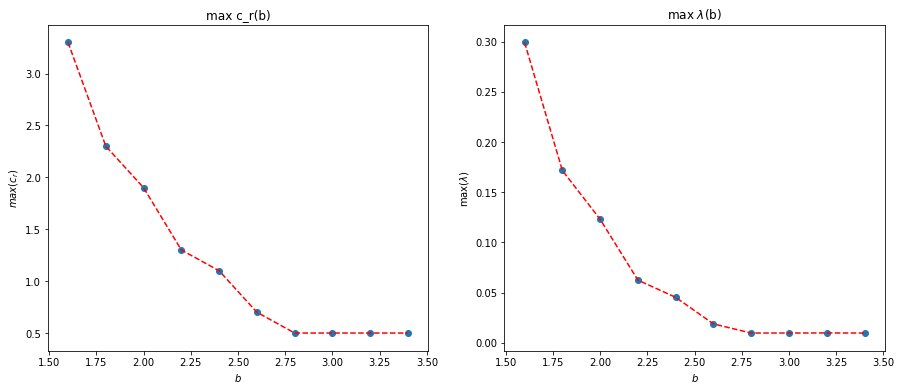

In [25]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(bs, best_c, 'r--')
plt.scatter(bs, best_c)
plt.ylabel('$max(c_r)$')
plt.xlabel('$b$')    
plt.title('max c_r(b)')

plt.subplot(122)
plt.plot(bs, best_l, 'r--')
plt.scatter(bs, best_l)
plt.ylabel('$\max (\lambda)$')
plt.xlabel('$b$')    
plt.title('max $\lambda$(b)')
plt.show()

In [26]:
lmbd_max = {}
for ind,b in enumerate(bs):
    lmbd_max[b] = indx[ind]

In [27]:
lmbd_max

{1.6: 4,
 1.8: 9,
 2.0: 11,
 2.2: 14,
 2.4: 15,
 2.6: 17,
 2.8: 18,
 3.0: 18,
 3.2: 18,
 3.4: 18}

# Параметры $\lambda$ и  $\gamma$

Посчитаем параметры
$$
\lambda_1 = \frac{\sum E_r}{\sum H}
$$

$$
\gamma = \frac{\frac{m_r}{2} (c_r^2 - {c'}_r^2)}{H_r} = \frac{T_r - T_r'}{H_r} = \lambda_{init} - \lambda_{end} 
$$

от $\lambda_{init}$ при ограничении  $\lambda_{init}$ до max($\lambda_{init}$) для каждого $b$, при которых $\lambda_{end}$ не меняется.

Так же посчитаем:
    1. Наклон прямой, приближающей $\gamma$;
    2. Наклон прямой, приближающей $\lambda$;
    3. Точку персечения прямой (1) с 0;
    3. Точку персечения прямой (2) с биссектрисой;

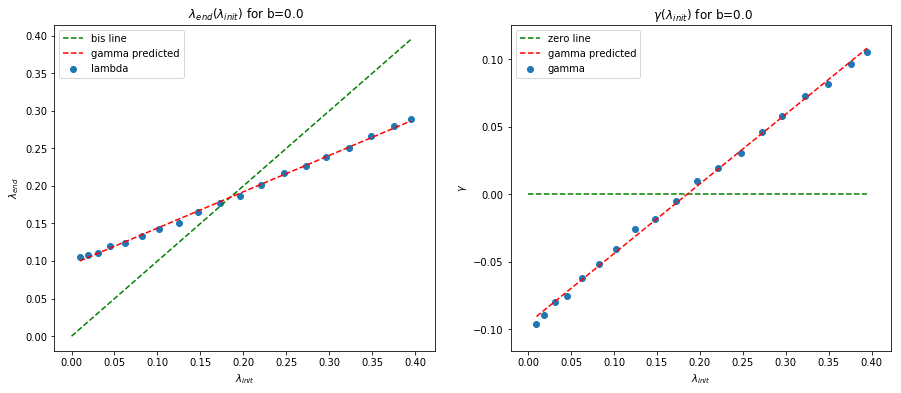

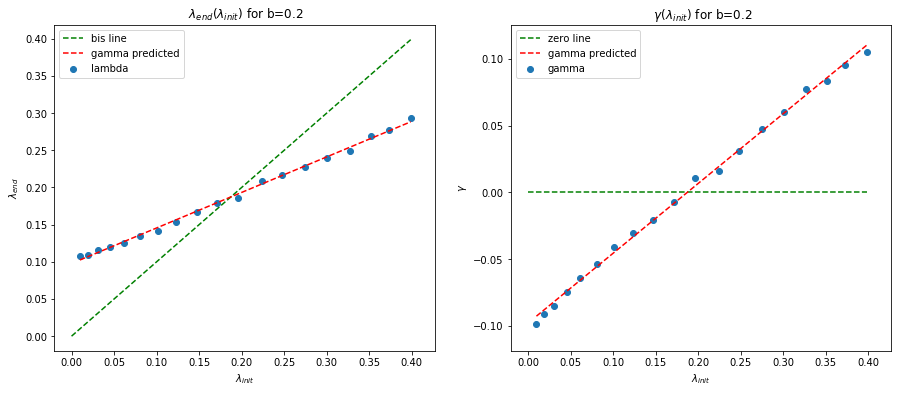

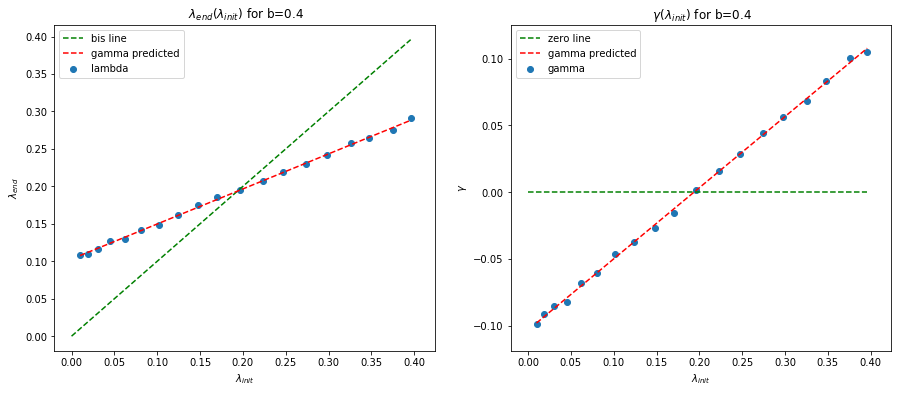

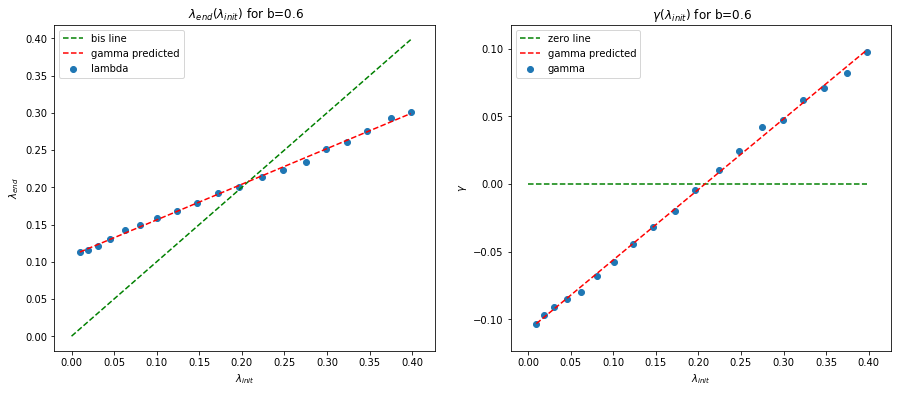

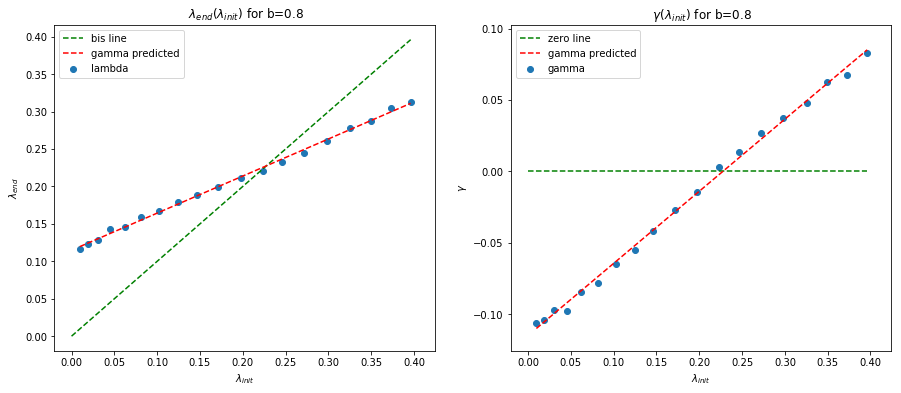

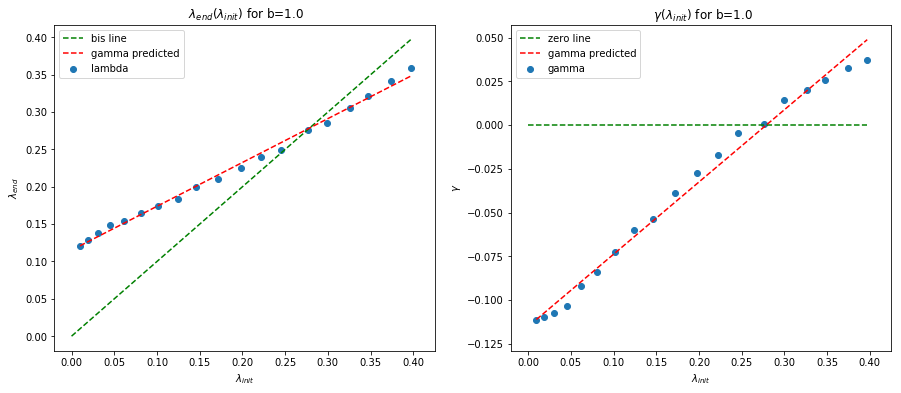

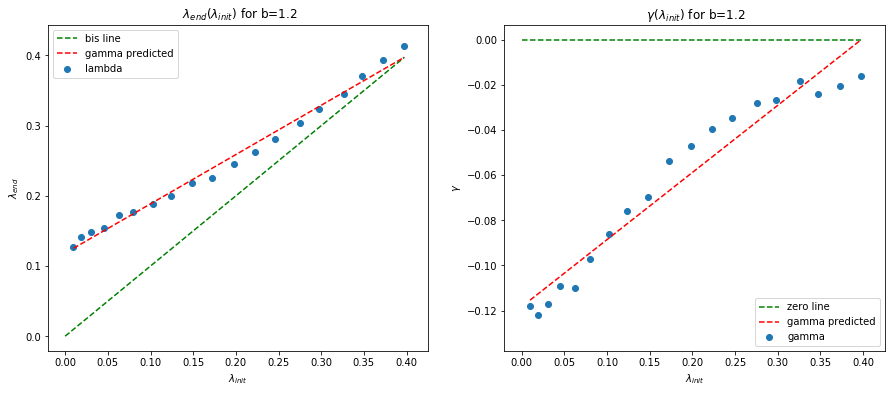

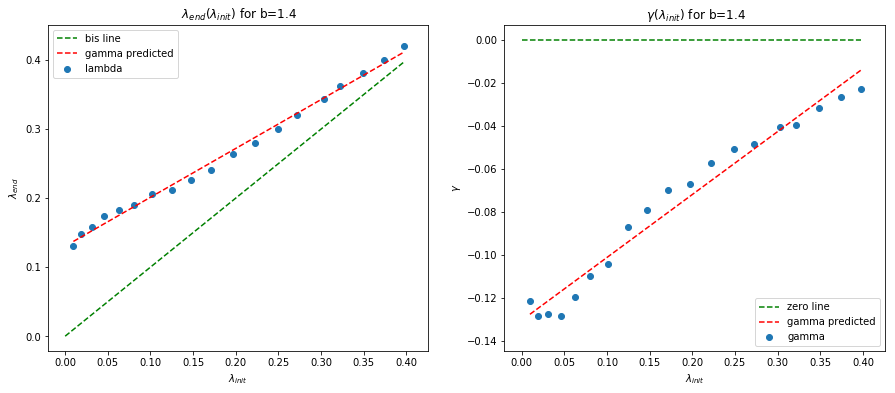

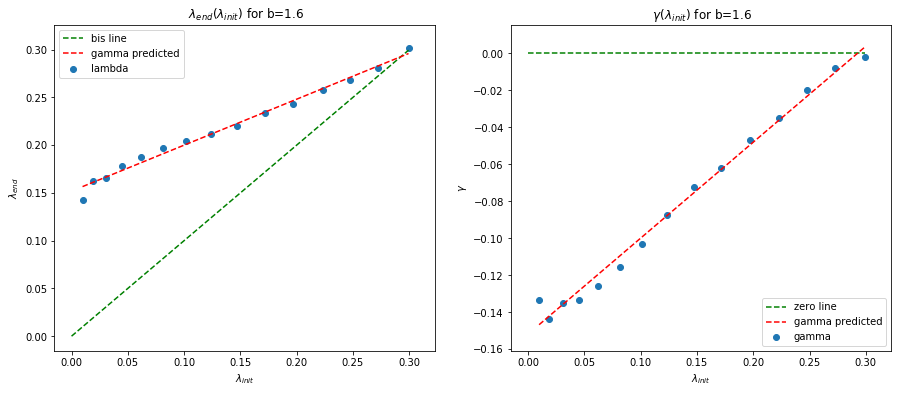

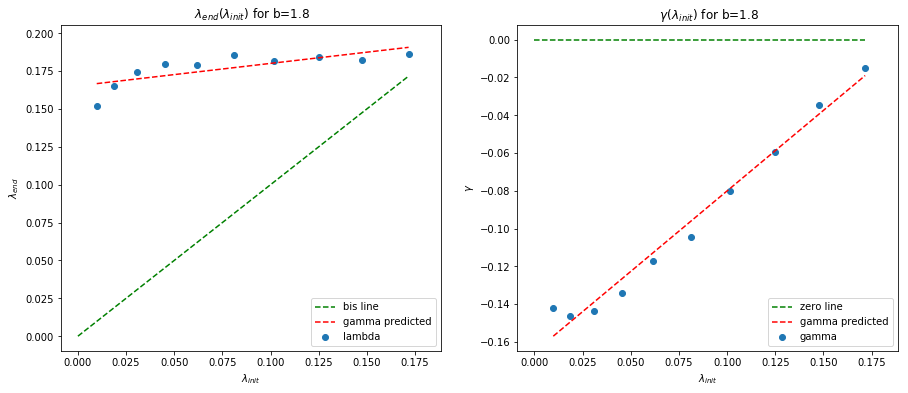

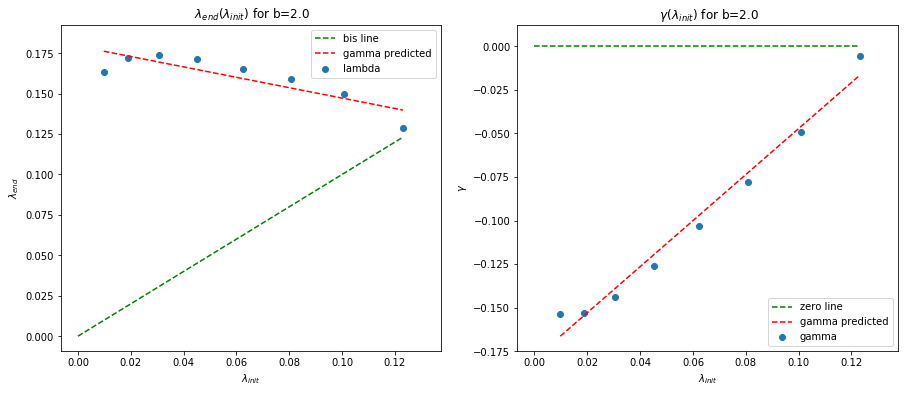

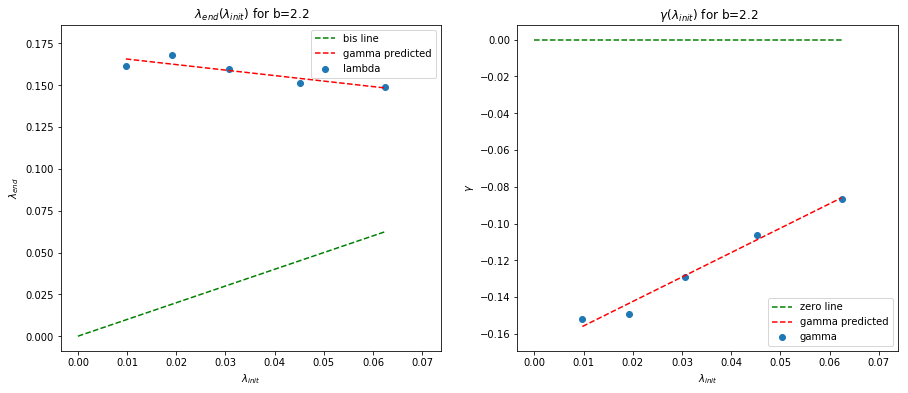

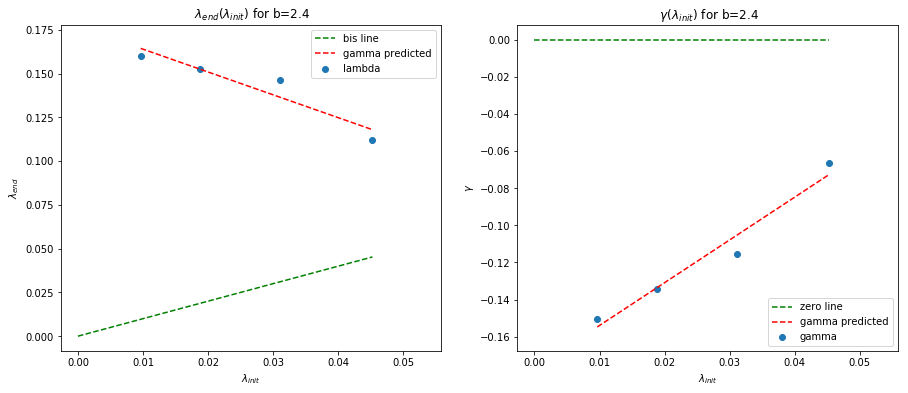

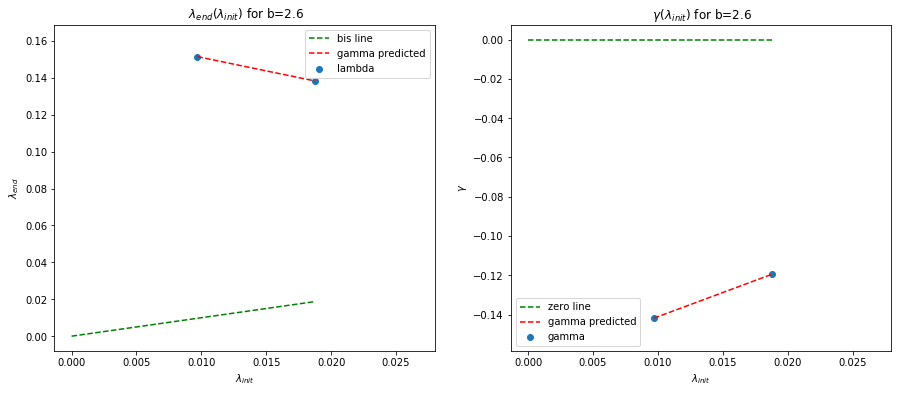

In [39]:
incline_lmbd = []
incline_gamma = []
intersection_lmbd = []
intersection_gamma = []
arr_b = []

for b in sorted(result_b.keys()):
    
    if float(b) in lmbd_max:
        x = (result_b[b]["l1"])[:-lmbd_max[float(b)]]
        arr = (result_b[b]["l1"] - result_b[b]["l2"])[:-lmbd_max[float(b)]]
        arr_lambda = (result_b[b]["l2"])[:-lmbd_max[float(b)]]
    else:
        x = result_b[b]["l1"]
        arr = result_b[b]["l1"] - result_b[b]["l2"]
        arr_lambda = (result_b[b]["l2"])
        
    if (len(x) > 1):
        
        arr_b.append(float(b))
        
        plt.figure(1, figsize=(15,6))
        
        plt.subplot(121)
        plt.scatter(x,arr_lambda, label = "lambda")
        plt.plot([0. ,np.max(x)], [0. ,np.max(x)], "g--",label = "bis line")
        fit = np.polyfit(x,arr_lambda,1)
        fit_fn = np.poly1d(fit) 
        plt.plot(x, fit_fn(x), 'r--', label = "gamma predicted")

        plt.xlabel('$\lambda_{init}$')
        plt.ylabel('$\lambda_{end}$')    
        plt.title(' $\lambda_{end}(\lambda_{init})$ for b=%s'%(b))
        plt.legend()
        
        #параметры
        incline_lmbd.append(fit[0])
        intersection_lmbd.append(fit[1]/(1 - fit[0]))
        
        plt.subplot(122)
        plt.scatter(x,arr, label = "gamma")
        plt.plot([0. ,np.max(x)], [0. ,0], "g--", label = "zero line")

        fit = np.polyfit(x,arr,1)
        fit_fn = np.poly1d(fit) 
        plt.plot(x, fit_fn(x), 'r--', label = "gamma predicted")

        plt.xlabel('$\lambda_{init}$')
        plt.ylabel('$\gamma$')    
        plt.title(' $\gamma(\lambda_{init})$ for b=%s'%(b))
        plt.legend()
        
        #параметры
        incline_gamma.append(fit[0])
        intersection_gamma.append(fit[1]/(1 - fit[0]))

        plt.show()



### Распределение tg угла наклона и точки пересечения с биссектрисой для $\lambda$ от $b$

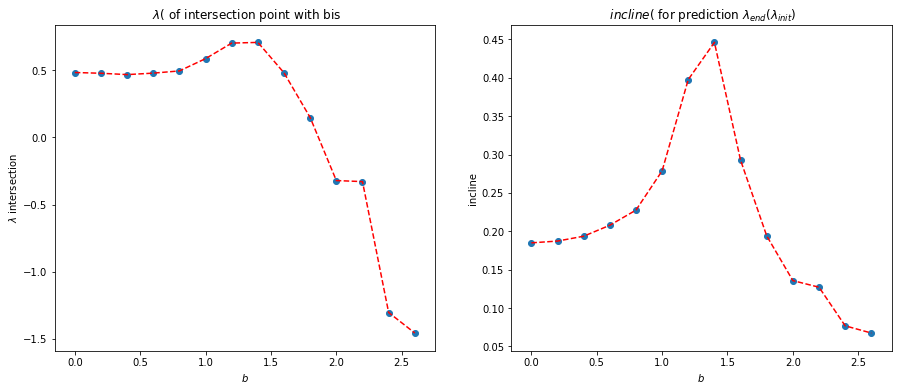

In [50]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(arr_b, incline_lmbd, 'r--')
plt.scatter(arr_b, incline_lmbd)

plt.xlabel('$b$')
plt.ylabel('$\lambda$ intersection')    
plt.title(' $\lambda(\b)$ of intersection point with bis')

plt.subplot(122)
plt.plot(arr_b, intersection_lmbd, 'r--')
plt.scatter(arr_b, intersection_lmbd)

plt.xlabel('$b$')
plt.ylabel('incline')    
plt.title(' $incline(\b)$ for prediction $\lambda_{end}(\lambda_{init})$')

plt.show()

### Распределение tg угла наклона и точки пересечения с биссектрисой для $\gamma$ от $b$

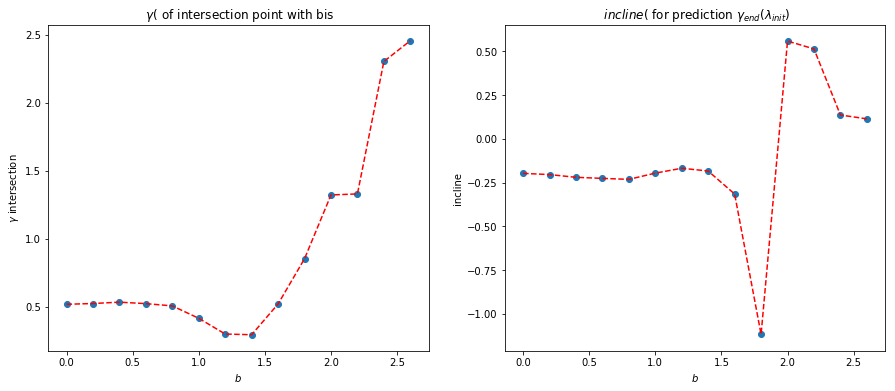

In [51]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(arr_b, incline_gamma)
plt.plot(arr_b, incline_gamma, 'r--')
plt.xlabel('$b$')
plt.ylabel('$\gamma$ intersection')    
plt.title(' $\gamma(\b)$ of intersection point with bis')

plt.subplot(122)
plt.scatter(arr_b, intersection_gamma)
plt.plot(arr_b, intersection_gamma, 'r--')
plt.xlabel('$b$')
plt.ylabel('incline')    
plt.title(' $incline(\b)$ for prediction $\gamma_{end}(\lambda_{init})$')

plt.show()

### Выводы:
    1. Для обоих параметров прослеживается линейная зависимость.
    2. Наклон $\gamma$ и точки пересечения с 0 почти константы от b при малых b.